In [29]:
from os.path import expanduser, join
import shutil
home = expanduser('~')
src = 'My_scripts_Local/Models_Local/ThalRNN/saved_models/'
dest = 'Dropbox/Trained_models/ThalRNN/saved_models/'
shutil.copytree(join(home,src), join(home,dest))

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import importlib
from os.path import join

import task
from task import generate_trials

import train
from train import get_default_hp

from network import Model

import my_rnn_functions as mrnn
importlib.reload(mrnn)

<module 'my_rnn_functions' from '/Users/svasquez91/My_scripts_Local/Models_Local/ThalRNN/my_rnn_functions.py'>

In [41]:
model_dir = './saved_models/debug'
hp = {'learning_rate': 0.001, 'n_rnn': 500, 'target_perf': 0.9,
          'use_separate_input': True, 'activation': 'relu',
          'use_TC_arc': True, 'type_TC_arc': 'basic'}
ruleset=ruleset='ctx_multi_sensory_delay'
default_hp = get_default_hp(ruleset)
if hp is not None:
    default_hp.update(hp)
hp = default_hp
hp['seed'] = 1
hp['rng'] = np.random.RandomState(1)

In [35]:
tf.keras.backend.clear_session()

In [4]:
model = Model(model_dir, hp=hp)

W0128 15:43:22.840037 4584977856 deprecation.py:323] From /Users/svasquez91/My_scripts_Local/Models_Local/ThalRNN/network.py:677: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0128 15:43:22.841838 4584977856 deprecation.py:323] From /Users/svasquez91/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0128 15:43:22.852021 4584977856 deprecation.py:506] From /Users/svasquez91/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using K

Variables being optimized:
<tf.Variable 'sen_input/kernel:0' shape=(65, 500) dtype=float32>
<tf.Variable 'sen_input/bias:0' shape=(500,) dtype=float32>
<tf.Variable 'rule_input/kernel:0' shape=(20, 500) dtype=float32>
<tf.Variable 'rnn/leaky_rnn_cell_separate_input/kernel:0' shape=(500, 500) dtype=float32>
<tf.Variable 'rnn/leaky_rnn_cell_separate_input/bias:0' shape=(500,) dtype=float32>
<tf.Variable 'output/kernel:0' shape=(500, 33) dtype=float32>
<tf.Variable 'output/bias:0' shape=(33,) dtype=float32>


sen_input/kernel:0
(65, 500)
rule_input/kernel:0
(20, 500)
rnn/leaky_rnn_cell_separate_input/kernel:0
(500, 500)
output/kernel:0
(500, 33)
sen_input/kernel:0
(65, 500)
rule_input/kernel:0
(20, 500)
rnn/leaky_rnn_cell_separate_input/kernel:0
(500, 500)
output/kernel:0
(500, 33)


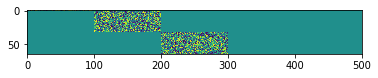

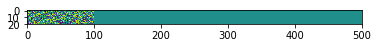

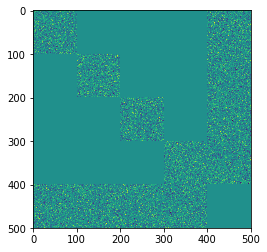

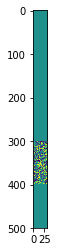

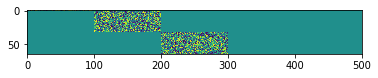

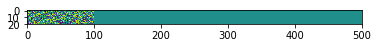

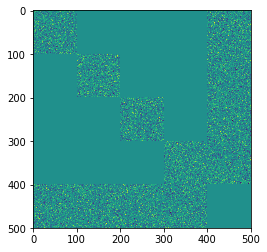

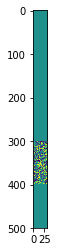

In [9]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    model.set_TC_architecture(sess)
    
    for v in model.var_list:
        if 'kernel' in v.name or 'weight' in v.name:
            # Connection weights
            print(v.name)
            print(v.shape)
            plt.figure()
            plt.imshow(v.eval())

In [54]:
def set_TC_architecture(model, sess, arc_type='basic'):
    """Set weight matrices according to chosen thalamocortical architecture

    Args:
        sess: tensorflow session
        arc_type: type of thalamocortical architecture
    """

    n_input = model.hp['n_input']
    for v in model.var_list:
        if 'kernel' in v.name or 'weight' in v.name:
            # Connection weights
            w_val = sess.run(v)
            print(v.name)
            print(v.shape)
            if 'sen_input' in v.name and not 'rnn' in v.name:
                # go cue input weights
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes=[0],
                                             post_node_indexes=range(0,100))
                # sensory modality input weights
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes=range(1+0*hp['n_eachring'],1+1*hp['n_eachring']),
                                             post_node_indexes=range(100,200))
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes=range(1+1*hp['n_eachring'],1+2*hp['n_eachring']),
                                             post_node_indexes=range(200,300))
                
            elif 'rule_input' in v.name and not 'rnn' in v.name:
                # rule input weights
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes='all',#pre_node_indexes=range(hp['n_input']-hp['n_rule'],hp['n_input']),
                                             post_node_indexes=range(0,100))
                
            elif 'rnn' in v.name:
                # recurrent weights
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes=range(0,100),
                                             post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']),
                                             keep_recurrency=True) #go and rule module
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes=range(100,200),
                                             post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']),
                                             keep_recurrency=True) #mod 1 module
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes=range(200,300),
                                             post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']),
                                             keep_recurrency=True) #mod 1 module
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes=range(300,400),
                                             post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']),
                                             keep_recurrency=True) #motor module
                w_val = reduce_weight_matrix(w_val,
                                             pre_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']),
                                             post_node_indexes=range(0,hp['n_rnn']-100),
                                             keep_recurrency=False) #thalamus module
                
            elif 'output' in v.name:
                # output weights
                w_val = reduce_weight_matrix(w_val.T,
                                             pre_node_indexes='all',
                                             post_node_indexes=range(300,400)).T
                
            sess.run(v.assign(w_val))
            plt.figure()
            plt.imshow(v.eval())
    
    return model

def reduce_weight_matrix(weights, pre_node_indexes='all', post_node_indexes='all', keep_recurrency=False):
    if pre_node_indexes == 'all':
        pre_node_indexes = range(weights.shape[0])
    if post_node_indexes == 'all':
        post_node_indexes = range(weights.shape[1])
        
    weights_to_zero = np.setdiff1d(range(weights[0].shape[0]),post_node_indexes)
    
    if keep_recurrency:
        if weights.shape[0] == weights.shape[1]:
            weights_to_zero = np.setdiff1d(weights_to_zero,pre_node_indexes)
        else:
            print('Weight matrix is not squared!')
        
    if len(weights_to_zero.shape):
        weights[np.ix_(pre_node_indexes,weights_to_zero)] = 0
        
    return weights

In [165]:
inputs = tf.keras.Input((None, hp['n_input']), name='inputs')
rnn = tf.keras.layers.SimpleRNN(hp['n_rnn'], return_sequences=True, name='rnn')(inputs)
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_output']), name='outputs')(rnn)

In [166]:
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [171]:
weights = model.get_weights()

(68, 500)
(500, 500)
(500,)
(500, 33)
(33,)


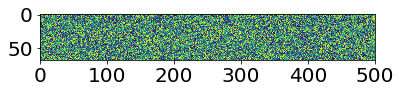

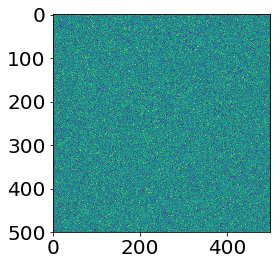

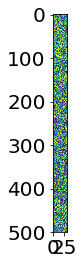

In [172]:
for w in weights:
    print(w.shape)
    if len(w.shape)>1:
        plt.figure()
        plt.imshow(w)

In [46]:
def reduce_weight_matrix(weights, pre_node_indexes='all', post_node_indexes='all', keep_recurrency=False):
    if pre_node_indexes == 'all':
        pre_node_indexes = range(weights.shape[0])
    if post_node_indexes == 'all':
        post_node_indexes = range(weights.shape[1])
        
    weights_to_zero = np.setdiff1d(range(weights[0].shape[0]),post_node_indexes)
    
    if keep_recurrency:
        if weights.shape[0] == weights.shape[1]:
            weights_to_zero = np.setdiff1d(weights_to_zero,pre_node_indexes)
        else:
            print('Weight matrix is not squared!')
        
    if len(weights_to_zero.shape):
        weights[np.ix_(pre_node_indexes,weights_to_zero)] = 0
        
    return weights

In [159]:
def sparsify_weight_matrix(weights, perc_weights_to_zero):
    
    seed = 1
    np.random.seed(seed)
    
    n_weights_to_zero = int(len(weights.flatten())*perc_weights_to_zero)
    
    all_indexes = [(i,j) for i in range(weights.shape[0]) for j in range(weights.shape[1])]
    
    sampled_indexes = np.array([all_indexes[i] for i in np.random.choice(range(len(all_indexes)),
                                                                         size=n_weights_to_zero)]).T
    weights[tuple(sampled_indexes)] = 0
    
    return weights

In [175]:
input_to_rnn_w = sparsify_weight_matrix(weights[0], 0.2)

In [177]:
sum(input_to_rnn_w.flatten()==0)/len(input_to_rnn_w.flatten())

0.18132352941176472

In [169]:
#n_input = 1+num_ring*n_eachring+n_rule
input_to_rnn_w = weights[0]

# go and rule inputs to rnn
input_to_rnn_w = reduce_weight_matrix(input_to_rnn_w,pre_node_indexes=[0],post_node_indexes=range(0,100))
input_to_rnn_w = reduce_weight_matrix(input_to_rnn_w,pre_node_indexes=range(hp['n_input']-hp['n_rule'],hp['n_input']),post_node_indexes=range(0,100))

# modalities to rnn
input_to_rnn_w = reduce_weight_matrix(input_to_rnn_w,pre_node_indexes=range(1+0*hp['n_eachring'],1+1*hp['n_eachring']),post_node_indexes=range(100,200))
input_to_rnn_w = reduce_weight_matrix(input_to_rnn_w,pre_node_indexes=range(1+1*hp['n_eachring'],1+2*hp['n_eachring']),post_node_indexes=range(200,300))

In [130]:
#n_rnn = n_rnn_go_contex + n_rnn_mod1 + n_rnn_mod2 + n_rnn_motor + n_rnn_thalamus
rnn_w = weights[1]

# cortex modules to thalamus
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(0,100),post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']), keep_recurrency=True) #go and rule module
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(100,200),post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']), keep_recurrency=True) #mod 1 module
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(200,300),post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']), keep_recurrency=True) #mod 1 module
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(300,400),post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']), keep_recurrency=True) #motor module

# thalamus module to cortex
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']),post_node_indexes=range(0,hp['n_rnn']-100), keep_recurrency=False) #thalamus module


In [131]:
#n_output = n_eachring+1
rnn_to_output_w = weights[3]

# rnn to outputs
rnn_to_output_w = reduce_weight_matrix(rnn_to_output_w.T,pre_node_indexes='all',post_node_indexes=range(300,400)).T

In [132]:
sum(rnn_w.flatten()==0).astype('int')/len(rnn_w.flatten())

0.52004

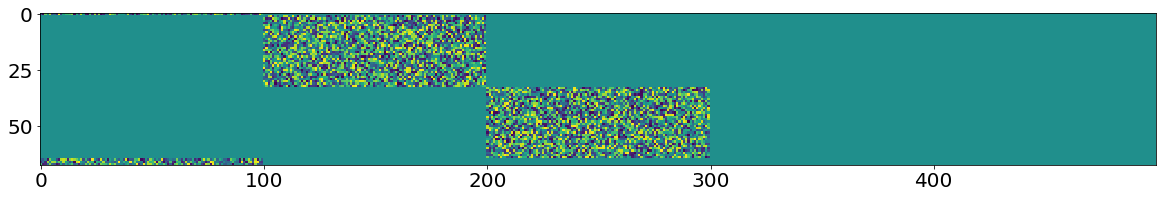

In [50]:
plt.figure(figsize=[20,20])
plt.imshow(input_to_rnn_w)
#plt.plot(input_to_rnn_w[0,:])

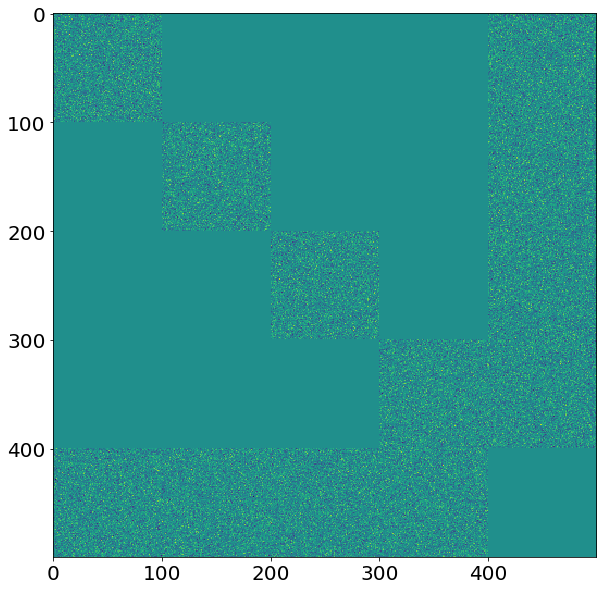

In [51]:
plt.figure(figsize=[10,10])
plt.imshow(rnn_w)
#plt.plot(rnn_w[0,:])

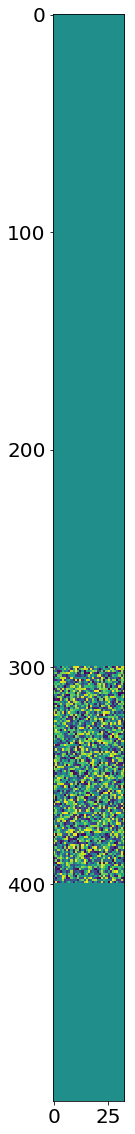

In [52]:
plt.figure(figsize=[20,20])
plt.imshow(rnn_to_output_w)
#plt.plot(rnn_to_output_w[0,:])

----

In [25]:
input_mod1 = tf.keras.Input((None, hp['n_eachring']), name='input_mod1')
input_mod2 = tf.keras.Input((None, hp['n_eachring']), name='input_mod2')
input_context_and_go = tf.keras.Input((None, hp['n_rule']+1), name='input_context_and_go')

rnn_mod1 = tf.keras.layers.SimpleRNN(hp['n_rnn'], return_sequences=True, name='rnn_mod1')(input_mod1)
dense_mod1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_dense_CT']), name='dense_mod1')(rnn_mod1)

rnn_mod2 = tf.keras.layers.SimpleRNN(hp['n_rnn'], return_sequences=True, name='rnn_mod2')(input_mod2)
dense_mod2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_dense_CT']), name='dense_mod2')(rnn_mod2)

rnn_context_and_go = tf.keras.layers.SimpleRNN(hp['n_rnn_contexts'], 
                                               return_sequences=True, 
                                               name='rnn_context_and_go')(input_context_and_go)
dense_context_and_go = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_dense_CT']), 
                                                       name='dense_context_and_go')(rnn_context_and_go)

thal_hub = tf.keras.layers.Concatenate(name='thalamic_hub')([dense_mod1,dense_mod2,dense_context_and_go])

rnn_motor = tf.keras.layers.SimpleRNN(hp['n_rnn'], return_sequences=True, name='rnn_motor')(thal_hub)

output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_output']), name='outputs')(rnn_motor)

TC_model = tf.keras.models.Model(inputs=[input_mod1, input_mod2, input_context_and_go], outputs=output)

TC_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [59]:
max_steps=1e6
step = 0
while step * hp['batch_size_train'] <= max_steps:
    try:
        # Training
        rule_train_now = hp['rng'].choice(hp['rule_trains'],
                                          p=hp['rule_probs'])
        # Generate a random batch of trials.
        # Each batch has the same trial length
        trial = generate_trials(
            rule_train_now, hp, 'random',
            batch_size=hp['batch_size_train'])

        all_inputs = np.transpose(trial.x,(1,0,2))
        inputs_mod1 = all_inputs[:,:,1:(1+hp['n_eachring'])]
        inputs_mod2 = all_inputs[:,:,(1+hp['n_eachring']):(1+2*hp['n_eachring'])]
        inputs_context_and_go = np.concatenate([all_inputs[:,:,:1],all_inputs[:,:,(1+2*hp['n_eachring']):]],axis=2)
        
        targets = np.transpose(trial.y,(1,0,2))
        history = TC_model.fit([inputs_mod1,inputs_mod2,inputs_context_and_go], targets, epochs=20)

        # Generating feed_dict.
        # feed_dict = tools.gen_feed_dict(model, trial, hp)
        # sess.run(model.train_step, feed_dict=feed_dict)

        step += 1

    except KeyboardInterrupt:
        print("Optimization interrupted by user")
        break

print("Optimization finished!")


Train on 64 samples
Epoch 1/20
64/64 [==============================] - 2s 27ms/sample - loss: 0.0172 - accuracy: 0.7510
Epoch 2/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0169 - accuracy: 0.7519
Epoch 3/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0168 - accuracy: 0.7513
Epoch 4/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0166 - accuracy: 0.7489
Epoch 5/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0163 - accuracy: 0.7503
Epoch 6/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0163 - accuracy: 0.7494
Epoch 7/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0161 - accuracy: 0.7490
Epoch 8/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0160 - accuracy: 0.7500
Epoch 9/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0160 - accuracy: 0.7519
Epoch 10/20
64/64 [==============================] - 0s 3ms/sample - loss: 0.01

In [68]:
import time

model.save("./saved_models/my_TC_model_" + time.strftime("%Y%m%d-%H%M%S") + ".h5")
#model.save_weights('./checkpoints/my_checkpoint')

----

In [ ]:
import thalnet as TN
importlib.reload(TN)

In [14]:
tdim = None
batch_size = hp['batch_size_train']

inputs_sizes = [[batch_size,tdim,hp['n_eachring']+1], #[Batch, Time, Num_units]
                [batch_size,tdim,hp['n_eachring']],
                [batch_size,tdim,hp['n_rule']],
                None]

outputs_sizes = [None,
                 None,
                 None,
                 hp['n_output']] #[Num_units]

total_input_size = np.sum([sz[2] for sz in inputs_sizes if sz is not None])
total_output_size = np.sum([sz for sz in outputs_sizes if sz is not None])

rule_train_now = hp['rng'].choice(hp['rule_trains'],
                                          p=hp['rule_probs'])

trial = generate_trials(
    rule_train_now, hp, 'random',
    batch_size=hp['batch_size_train'])

inputs = np.transpose(trial.x,(1,0,2))
targets = np.transpose(trial.y,(1,0,2))

In [ ]:
importlib.reload(TN)
tf.keras.backend.clear_session()

thalnet_network = TN.ThalNet(TN.SimpleRNNCell, inputs_sizes, outputs_sizes, n_modules=hp['n_modules'])

# thalnet_network = tf.keras.models.Sequential([TN.ThalNet(TN.SimpleRNNCell, inputs_sizes, 
#                                                          outputs_sizes, n_modules=hp['n_modules'])])

                                                         

#print(inputs.shape)
outputs = thalnet_network(inputs)
print(outputs.shape)

In [73]:
thalnet_network.compile(loss="mse", optimizer="adam", run_eagerly=True)
history = thalnet_network.fit(trial.x, trial.y, epochs=1)

Train on 165 samples
165/165 [==============================] - 17s 101ms/sample - loss: 0.1174


In [ ]:
max_steps=1e2 #1e6
step = 0
while step * hp['batch_size_train'] <= max_steps:
    try:
        # Validation
        # if step % display_step == 0:
        #     log['trials'].append(step * hp['batch_size_train'])
        #     log['times'].append(time.time() - t_start)
        #     log = do_eval(sess, model, log, hp['rule_trains'])
        #     # if log['perf_avg'][-1] > model.hp['target_perf']:
        #     # check if minimum performance is above target
        #     if log['perf_min'][-1] > model.hp['target_perf']:
        #         print('Perf reached the target: {:0.2f}'.format(
        #             hp['target_perf']))
        #         break
        #
        #     if rich_output:
        #         display_rich_output(model, sess, step, log, model_dir)

        # Training
        rule_train_now = hp['rng'].choice(hp['rule_trains'],
                                          p=hp['rule_probs'])
        # Generate a random batch of trials.
        # Each batch has the same trial length
        trial = generate_trials(
            rule_train_now, hp, 'random',
            batch_size=hp['batch_size_train'])

        inputs = np.transpose(trial.x,(1,0,2))
        targets = np.transpose(trial.y,(1,0,2))
        history = thalnet_network.fit(inputs, targets, epochs=20)

        # Generating feed_dict.
        # feed_dict = tools.gen_feed_dict(model, trial, hp)
        # sess.run(model.train_step, feed_dict=feed_dict)

        step += 1

    except KeyboardInterrupt:
        print("Optimization interrupted by user")
        break

print("Optimization finished!")


In [7]:
# upgrade the .py files and copy all the other files to the outtree
!tf_upgrade_v2 \
    --intree v1_4/ \
    --outtree v2_0/ \
    --reportfile tree_report.txt

INFO line 114:13: Renamed 'tf.Session' to 'tf.compat.v1.Session'
INFO line 224:13: Renamed 'tf.Session' to 'tf.compat.v1.Session'
INFO line 666:13: Renamed 'tf.Session' to 'tf.compat.v1.Session'
WARNING line 915:4: *.save requires manual check. (This warning is only applicable if the code saves a tf.Keras model) Keras model.save now saves to the Tensorflow SavedModel format by default, instead of HDF5. To continue saving to HDF5, add the argument save_format='h5' to the save() function.
INFO line 934:9: Renamed 'tf.Session' to 'tf.compat.v1.Session'
TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 1 files
Detected 1 issues that require attention
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
File: v1_4/my_rnn_functions.py
--------------------------------------------------------------------------------
v1_4/my_rnn_functions.py:915:4: WARNING: *.save req